In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.graph_objects as go

df_raw = pd.read_csv('dataecommerce.csv', encoding='ISO-8859-1')
df=df_raw.copy()
df.shape
df.head(20)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [428]:

df.tail()
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [430]:
df.columns
df.info()
df.describe()
df.duplicated().sum() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


5268

In [434]:
# there 5268 duplicate rows are there
df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [436]:
### deal with missing values

df.isna().sum()*100/len(df)




InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [584]:
# we droup rows where missing value isless than 3%
df=df.dropna(subset=["Description"])
df["Description"].isna().sum()
df=df[df["Quantity"]>0]
df["Quantity"].isna().sum()
df=df[df["UnitPrice"]>0]
df=df.dropna(subset=['CustomerID'])
df

,Quantity,InvoiceDate,UnitPrice,CustomerID,Totalsale
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


In [440]:
 
df["CustomerID"].isna().sum()

0

In [588]:
df1=df.reset_index(drop=True)
 
def remove_outlier(df1,column):
    q1=df[column].quantile(.25)
    q3=df[column].quantile(.75)
    IQR=q3-q1
    lower_limit=q1-1.5*IQR
    upper_limit=q3+1.5*IQR
    return df[(df[column]>=lower_limit)&(df[column]<=upper_limit)]

df=remove_outlier(df1,"Quantity")
df=remove_outlier(df,"UnitPrice")
df["CustomerID"].nunique()-df1["CustomerID"].nunique() # this means that we are losing customer



-13

In [448]:
df.dtypes
df[['CustomerID', 'InvoiceNo', 'StockCode']]=df[['CustomerID', 'InvoiceNo', 'StockCode']].astype(str)
df[["Quantity","UnitPrice"]]=df[["Quantity","UnitPrice"]].astype(float)
df["TotalSale"]=df["Quantity"]*df["UnitPrice"]
df.head(1)






,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSale
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.3


In [594]:
# Lets analyse recency(number of days between a customer's last purchase date and a chosen reference date)
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])
Reference_date=df["InvoiceDate"].max()+pd.Timedelta(days=1)
df["Totalsale"]=df["Quantity"]*df["UnitPrice"]
 
result=df.groupby("CustomerID").agg({"InvoiceDate":lambda x:(Reference_date-x.max()).days,
                             "InvoiceNo":lambda x:x.nunique(),
                             "Totalsale":lambda x:x.sum()}).reset_index()
result.columns=["CustomerID","Recency","Frequency","Monetary"]
result.head(2)

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,3243.33
1,12348.0,249,3,90.20


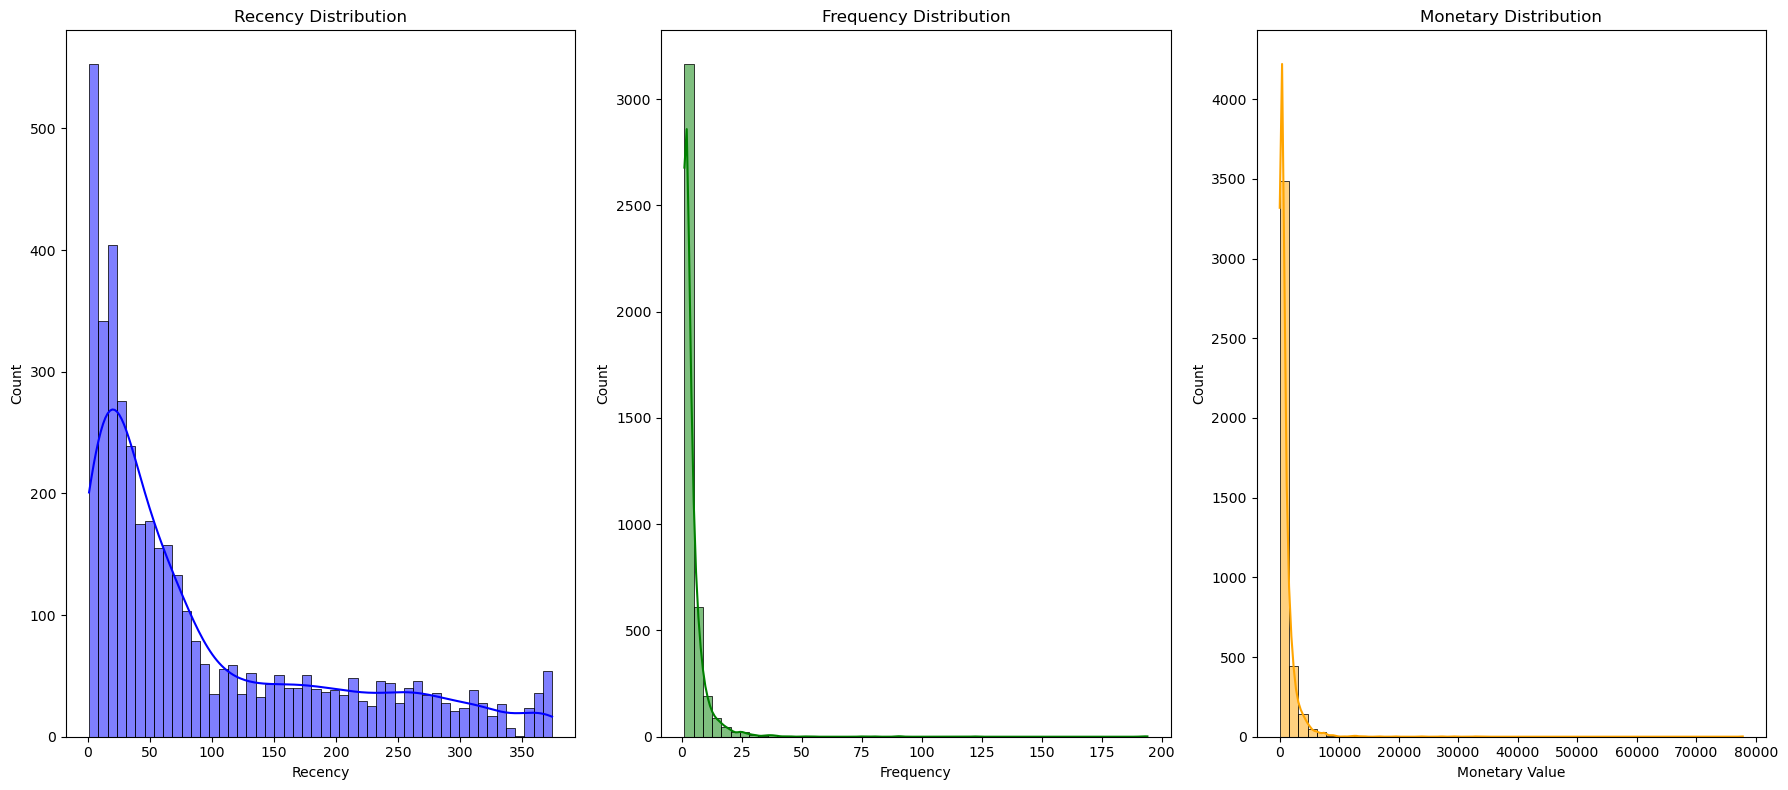

In [610]:
def date_plot(result):
    
    fig,axes=plt.subplots(1,3,figsize=(18,8))
    
    sns.histplot(result["Recency"],bins=50,kde=True,ax=axes[0],color="blue")
    axes[0].set_title("Recency Distribution")
    axes[0].set_xlabel("Recency")
    axes[0].set_ylabel("Count")

    sns.histplot(result['Frequency'], bins=50, kde=True, ax=axes[1], color='green')
    axes[1].set_title('Frequency Distribution')
    axes[1].set_xlabel('Frequency')

    sns.histplot(result['Monetary'], bins=50, kde=True, ax=axes[2], color='orange')
    axes[2].set_title('Monetary Distribution')
    axes[2].set_xlabel('Monetary Value')

    plt.tight_layout()
    plt.show()

date_plot(result)
    
 

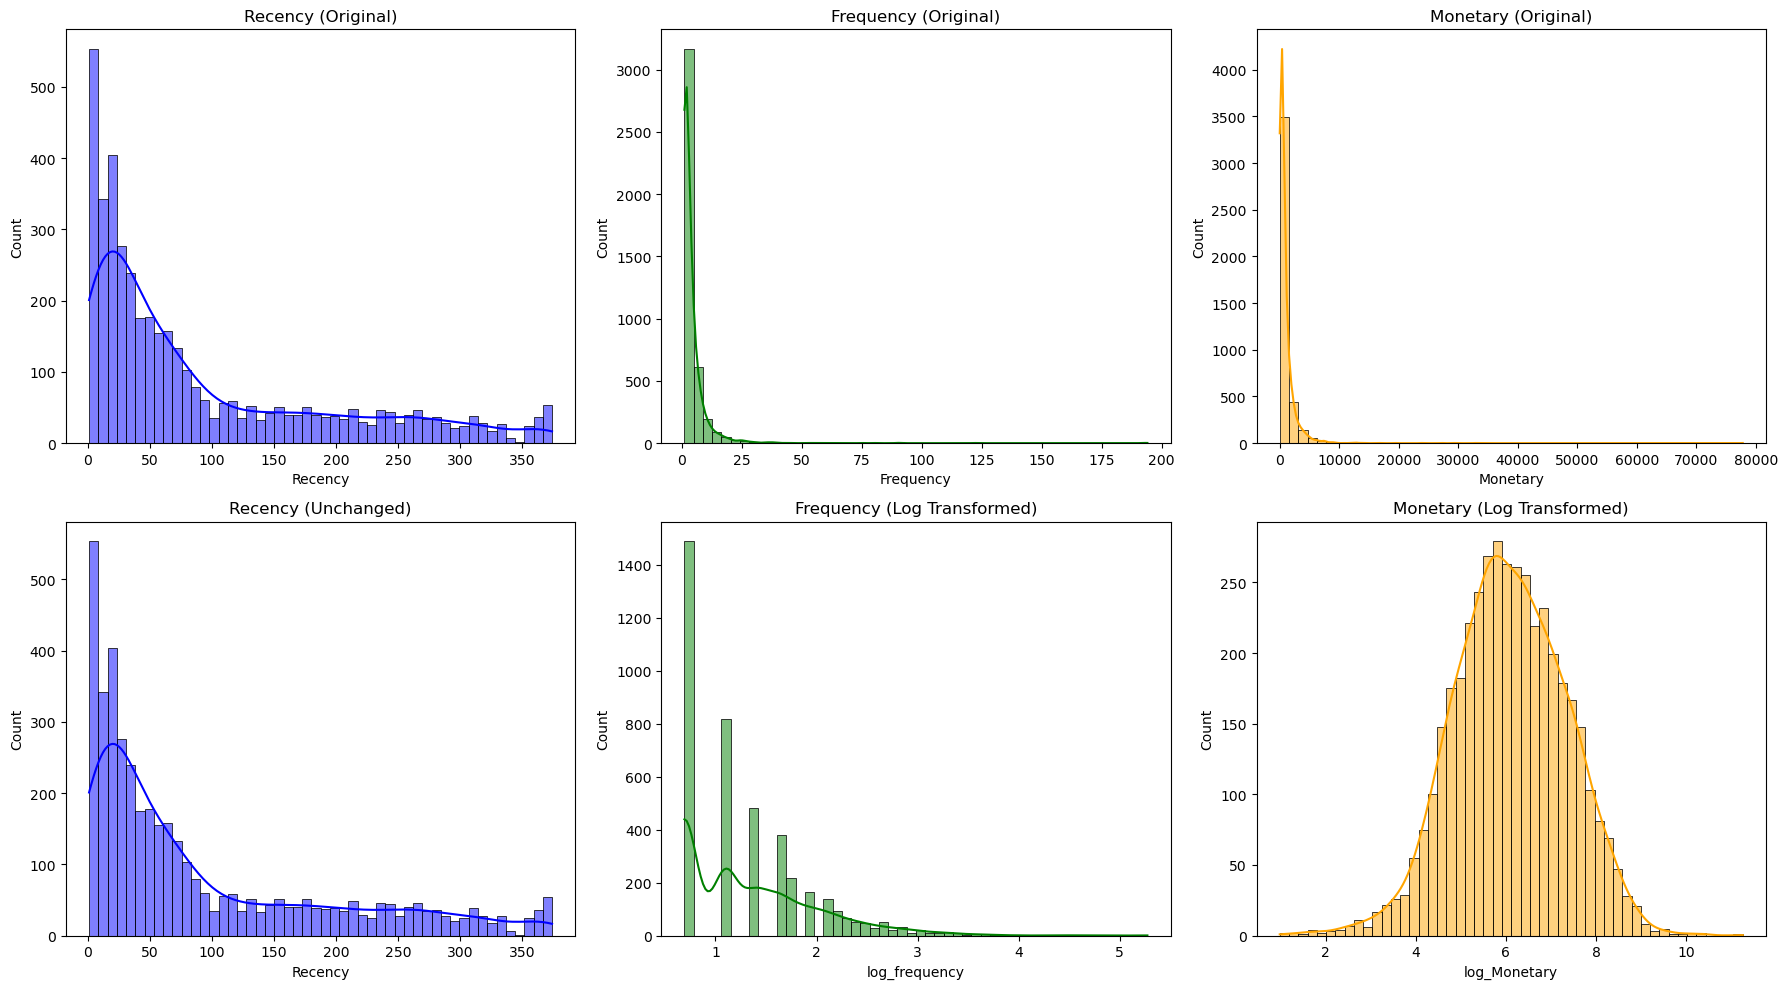

In [620]:
 # Recency is managable but frequency and monetary is highly rightly skewed. we need to transform them in log
result["log_frequency"]=np.log1p(result["Frequency"].astype(float))
result["log_Monetary"]=np.log1p(result["Monetary"].astype(float))
result.head(2)
def log_data_plot(result):
    fig,axes=plt.subplots(2,3,figsize=(18,10))

    sns.histplot(result['Recency'], bins=50, kde=True, ax=axes[0, 0], color='blue')
    axes[0, 0].set_title('Recency (Original)')

    sns.histplot(result['Frequency'], bins=50, kde=True, ax=axes[0, 1], color='green')
    axes[0, 1].set_title('Frequency (Original)')

    sns.histplot(result['Monetary'], bins=50, kde=True, ax=axes[0, 2], color='orange')
    axes[0, 2].set_title('Monetary (Original)')

    sns.histplot(result['Recency'], bins=50, kde=True, ax=axes[1, 0], color='blue')
    axes[1, 0].set_title('Recency (Unchanged)')

    sns.histplot(result['log_frequency'], bins=50, kde=True, ax=axes[1, 1], color='green')
    axes[1, 1].set_title('Frequency (Log Transformed)')

    sns.histplot(result['log_Monetary'], bins=50, kde=True, ax=axes[1, 2], color='orange')
    axes[1, 2].set_title('Monetary (Log Transformed)')

    plt.tight_layout()
    plt.show()

log_data_plot(result)



In [630]:
#
result[["Recency","log_Monetary","log_frequency"]].describe()
df1=result.copy()

In [638]:
def score_recency(x):
    if x <= 18:
        return 4
    elif x <= 51:
        return 3
    elif x <= 144:
        return 2
    else:
        return 1

def score_log_monetary(x):
    if x <= 5.253:
        return 1
    elif x <= 6.075:
        return 2
    elif x <= 6.959:
        return 3
    else:
        return 4

def score_log_frequency(x):
    if x <= 0.693:
        return 1
    elif x <= 1.099:
        return 2
    elif x <= 1.609:
        return 3
    else:
        return 4
scoring_function={"Recency":score_recency,
                 "log_frequency":score_log_frequency,
                 "log_Monetary":score_log_monetary}
for col,func in scoring_function.items():
    suffix = col if col == 'Recency' else col.split("_")[1]
    df1[f'{suffix}_score'] = df1[col].apply(func)
df1.head(2)
df1

,CustomerID,Recency,Frequency,Monetary,log_frequency,log_Monetary,Recency_score,frequency_score,Monetary_score
0,12347.0,2,7,3243.33,2.079442,8.084664,4,4,4
1,12348.0,249,3,90.20,1.386294,4.513055,1,3,1
2,12349.0,19,1,918.10,0.693147,6.823395,3,2,3
3,12350.0,310,1,294.40,0.693147,5.688330,1,2,2
4,12352.0,36,7,986.34,2.079442,6.895014,3,4,3
...,...,...,...,...,...,...,...,...,...
4173,18280.0,278,1,119.15,0.693147,4.788741,1,2,1
4174,18281.0,181,1,46.92,0.693147,3.869533,1,2,1
4175,18282.0,8,2,99.63,1.098612,4.611450,4,2,1
4176,18283.0,4,16,2040.08,2.833213,7.621234,4,4,4


In [662]:
df1["RFM_segment"]=df1[["Recency_score","frequency_score","Monetary_score"]].astype(str).agg("".join,axis=1)
df1.head(2)
def cust_categry(code):
    if code in ["444", "443", "434", "344"]:
        return "Best Customer"
    elif code in ["344", "334", "433", "333"]:
        return "Loyal Customers"
    elif code.startswith('4') and code[1] in ['1', '2'] and code[2] in ['1', '2']:
        return 'New Customers'
    elif code[0] == '4' and code[2] == '4' and code[1] in ['1', '2']:
        return 'Potential Loyalists'
    elif code[0] in ['1', '2'] and code[1] in ['3', '4']:
        return 'At Risk Customers'
    elif code in ['111', '112', '121', '122']:
        return 'Lost Customers'
    else:
        return 'Other'
df1["Customer_Segment"]=df1["RFM_segment"].apply(cust_categry)
df1.groupby("Customer_Segment").size()*100/len(df1)


Customer_Segment
At Risk Customers      11.967449
Best Customer          22.355194
Lost Customers         19.243657
Loyal Customers         4.021063
New Customers           4.571565
Other                  37.673528
Potential Loyalists     0.167544
dtype: float64

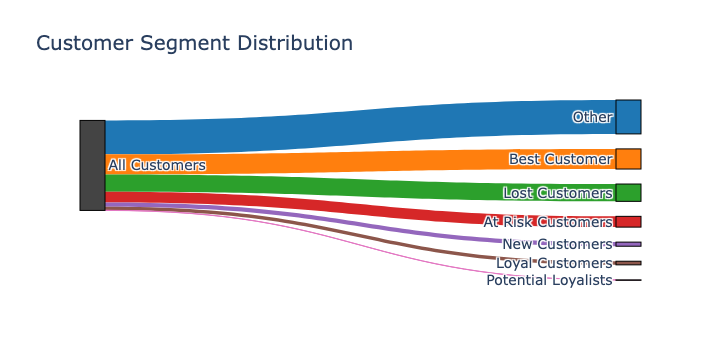

In [676]:
 

segment_percent = df1.groupby("Customer_Segment").size() * 100 / len(df1)
segments = segment_percent.index.tolist()       
values = segment_percent.values.tolist()  

sorted_data = sorted(zip(segments, values), key=lambda x: x[1], reverse=True)
segments_sorted, values_sorted = zip(*sorted_data)

labels = ["All Customers"] + list(segments_sorted)
source = [0] * len(segments_sorted)   
target = list(range(1, len(labels)))

 
colors = [
    "#1f77b4",   
    "#ff7f0e",   
    "#2ca02c",   
    "#d62728",   
    "#9467bd",   
    "#8c564b",   
    "#e377c2",   
    "#7f7f7f",   
    "#bcbd22",   
    "#17becf"    
]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=15,
        thickness=25,
        color=node_colors,
        line=dict(color="black", width=1)
    ),
    link=dict(
        source=source,
        target=target,
        value=values_sorted,
        color=colors[:len(source)],   
        hoverlabel=dict(bgcolor="white", font_size=12)
    )
)])
fig.update_layout(title_text="Customer Segment Distribution", font_size=14)
fig.show()



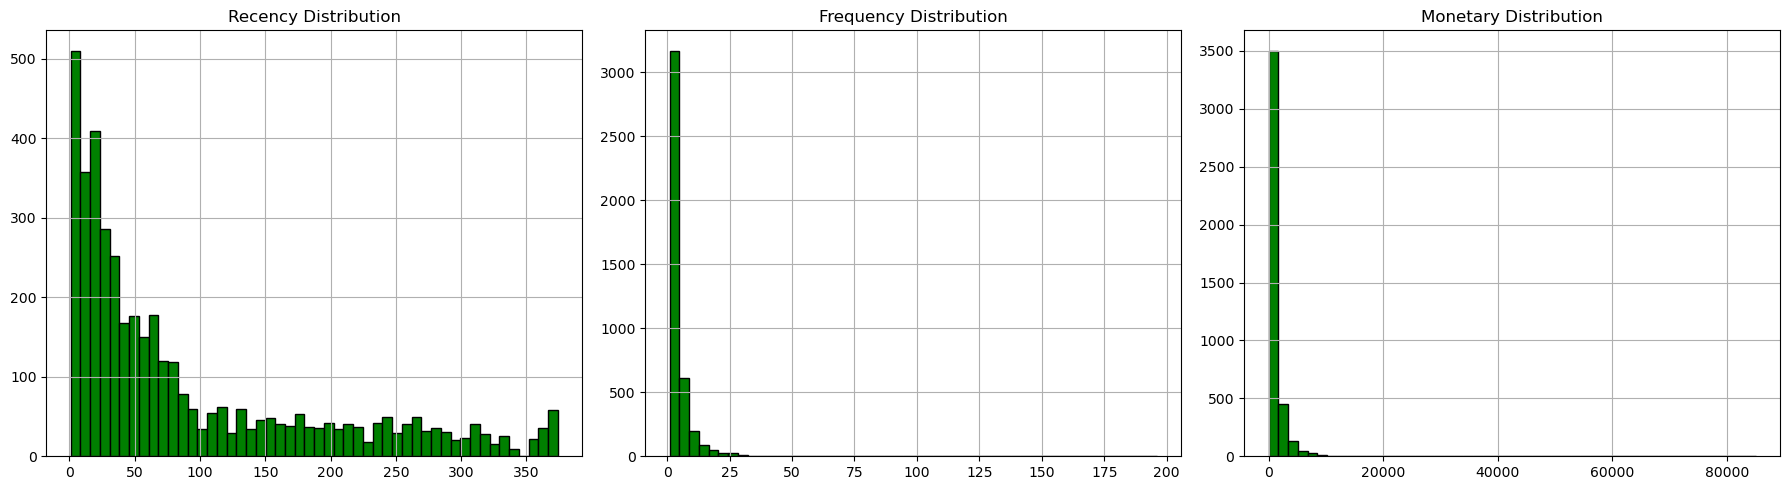

In [538]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
data_set[['Recency', 'Frequency', 'Monetary']].hist(bins=50,ax=axes,color="green",edgecolor="black")
axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [424]:
TotalSales_Revenue=df["TotalSale"].sum()
TotalQuantity_sold=df["Quantity"].sum()


In [263]:
df=df[df["InvoiceDate"]>="2011-01-01"]
df["Month_name"]=df["InvoiceDate"].dt.month_name()
df["Quarter"]="Q"+df["InvoiceDate"].dt.quarter.astype(str)
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'Month',
       'Month_name', 'Quarter'],
      dtype='object')

In [309]:
Month_Wise_sale=df.groupby(["Month","Month_name"])["TotalPrice"].sum().reset_index(name="Month_wise_sale")
Month_Wise_sale=Month_Wise_sale.sort_values(by="Month").set_index("Month")
Quarter_wise_sale=df.groupby("Quarter")["TotalPrice"].sum().reset_index(name="quarterlysale").sort_values(by="Quarter")
 
def cal_metrics(df,group_by,value,output_col,sort_by):
    return df.groupby(group_by)[value].sum().reset_index(name=output_col).sort_values(by=sort_by)
    
group_by=['StockCode', 'Description',"Month","Month_name"]
monthly_revenue = cal_metrics(df, group_by, 'TotalPrice', 'Product_Monthly_Revenue', 'Month')
monthly_quantity = cal_metrics(df, group_by, 'Quantity', 'Product_Monthly_Quantity', 'Month')

def cal_qrt(df,group_by,value,output_col,sort_by):
    return df.groupby(group_by)[value].sum().reset_index(name=output_col).sort_values(by=sort_by)
    
group_by=['StockCode', 'Description',"Quarter"]
quartly_revenue=cal_qrt(df,group_by,"TotalPrice","Product_quarterly_Revenue","Quarter")
quartly_quantity=cal_qrt(df,group_by,"Quantity","Product_quarterly_quantity","Quarter")
negative=df[ df["Quantity"]<0]
negative


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,Month_name,Quarter
42557,C540006,21306,SET/4 DAISY MIRROR MAGNETS,-1.0,2011-01-04 10:48:00,2.10,Unknown,United Kingdom,-2.10,1,January,Q1
42558,C540006,84352,SILVER CHRISTMAS TREE BAUBLE STAND,-1.0,2011-01-04 10:48:00,16.95,Unknown,United Kingdom,-16.95,1,January,Q1
42559,C540006,22423,REGENCY CAKESTAND 3 TIER,-1.0,2011-01-04 10:48:00,12.75,Unknown,United Kingdom,-12.75,1,January,Q1
42560,C540007,21055,TOOL BOX SOFT TOY,-6.0,2011-01-04 11:08:00,8.95,Unknown,United Kingdom,-53.70,1,January,Q1
42561,C540007,22274,FELTCRAFT DOLL EMILY,-6.0,2011-01-04 11:08:00,2.95,Unknown,United Kingdom,-17.70,1,January,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11.0,2011-12-09 09:57:00,0.83,Unknown,United Kingdom,-9.13,12,December,Q4
541541,C581499,M,Manual,-1.0,2011-12-09 10:28:00,224.69,Unknown,United Kingdom,-224.69,12,December,Q4
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5.0,2011-12-09 11:57:00,10.95,Unknown,United Kingdom,-54.75,12,December,Q4
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1.0,2011-12-09 11:58:00,1.25,Unknown,United Kingdom,-1.25,12,December,Q4
